# Обучение без учителя: метод главных компонент и кластеризация

Датасет https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [4]:
X_train = np.loadtxt("samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("samsung_HAR/samsung_test_labels.txt").astype(int)

In [5]:
X_train

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [6]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [13]:
X_test.shape, X_train.shape

((2947, 561), (7352, 561))

In [16]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [17]:
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [18]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [20]:
n_classes = np.unique(y).size
n_classes

6

Эти метки соответствуют:

1 - ходьбе

2 - подъему вверх по лестнице

3 - спуску по лестнице

4 - сидению

5 - стоянию

6 - лежанию

Отмасштабируйте выборку с помощью StandardScaler с параметрами по умолчанию.

In [22]:
scaler = StandardScaler()
X_scaled =scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [25]:
RANDOM_STATE = 17

pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)



n_components = 0
explained_ratio = 0
while explained_ratio < 0.9:
    explained_ratio += pca.explained_variance_ratio_[n_components]
    n_components += 1
n_components

65

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов

In [26]:
pca.explained_variance_ratio_[0]

0.5073822103501332

In [27]:
pca.components_

array([[ 3.22020289e-04, -2.65501561e-03, -1.83102105e-03, ...,
        -2.32255116e-02,  2.86959980e-02,  2.62231368e-02],
       [ 1.66786205e-02,  5.09240538e-04, -4.96277039e-03, ...,
         2.48285029e-02, -4.03643784e-02, -2.18803937e-02],
       [-3.34516218e-02,  1.85357867e-03,  9.01579462e-03, ...,
         9.27247047e-02, -6.63613925e-02, -4.42715263e-02],
       ...,
       [ 0.00000000e+00,  4.90746737e-17,  1.39802916e-17, ...,
        -7.59265715e-17, -5.72771840e-17, -4.15634289e-17],
       [-0.00000000e+00,  1.55544982e-16,  7.08595135e-16, ...,
        -2.68581687e-15, -5.83413134e-15,  5.83551887e-15],
       [-0.00000000e+00,  1.20650918e-16,  3.83251653e-16, ...,
        -1.82439046e-15, -4.03276689e-15,  4.16443444e-15]])

Визуализируйте данные в проекции на первые две главные компоненты.

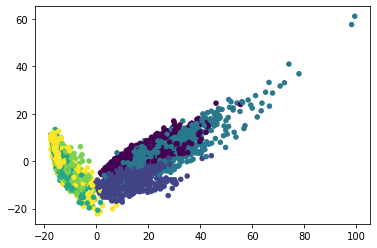

In [37]:
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1] , c=y, s=20, cmap='viridis')

Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

n_clusters = n_classes (число уникальных меток целевого класса)

n_init = 100

random_state = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [39]:
kmeans = KMeans(n_clusters = 6, n_init=100, random_state=RANDOM_STATE)

kmeans.fit(X_pca)
cluster_labels = kmeans.predict(X_pca)

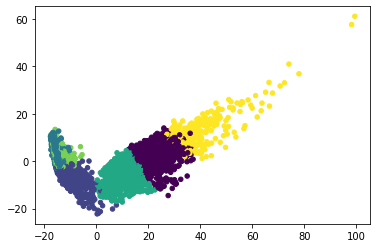

In [40]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis')

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм KMeans путает.

In [41]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,742,0,0,903,0,77,1722
подъем вверх по лестнице,295,2,0,1242,0,5,1544
спуск по лестнице,889,0,0,321,0,196,1406
сидение,0,451,91,1,1234,0,1777
стояние,0,566,0,0,1340,0,1906
лежание,0,330,1556,5,53,0,1944
все,1926,1349,1647,2472,2627,278,10299


In [57]:
for idx in tab.index[:-1]:
    print(idx, tab.loc[idx][:-1].max() / tab.loc[idx][:-1].sum())

ходьба 0.524390243902439
подъем вверх по лестнице 0.8044041450777202
спуск по лестнице 0.6322901849217639
сидение 0.6944288126055149
стояние 0.7030430220356768
лежание 0.8004115226337448


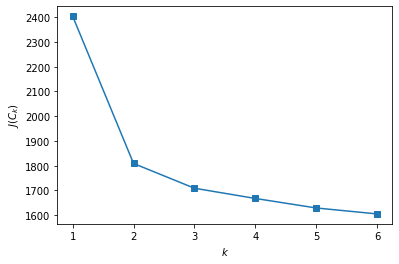

In [59]:
inertia = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 7), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [60]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (sklearn.metrics) для получившегося разбиения на кластеры и для KMeans с параметрами из задания к 4 вопросу.

In [62]:
print('Aglomerative: ', metrics.adjusted_rand_score(y, ag.labels_))

Aglomerative:  0.459874890109388
Kmeans:  0.419224271062724


In [63]:
kmeans = KMeans(n_clusters = 6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.predict(X_pca)
print('Kmeans: ', metrics.adjusted_rand_score(y, cluster_labels))

Kmeans:  0.419224271062724


Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.

Для классификации используйте метод опорных векторов – класс sklearn.svm.LinearSVC. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова – тут.

Настройте для LinearSVC гиперпараметр C с помощью GridSearchCV.

Обучите новый StandardScaler на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
В GridSearchCV укажите cv=3.

In [65]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [66]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [67]:
svc_cv = GridSearchCV(svc, param_grid=svc_params, cv=3)
svc_cv.fit(X_train_scaled, y_train)

C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\alexe\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.p

GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [68]:
svc_cv.best_params_

{'C': 0.1}

Какое значение гиперпараметра C было выбрано лучшим по итогам кросс-валидации?

In [70]:
y_predicted = svc_cv.predict(X_test_scaled)

In [71]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947
